# <br> DenseClus analysis for 2 big cities Jakarta and London<br>

### Information about data set:<br>
#### 1. Analysis was performed for sample about 1000 data from database. 
#### 2. Data were taken for two cities with the higest number of active hotels. <br> 


In [122]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

## Importing Libraries

In [123]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set()
### libraries to reduce data
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant
from sklearn import metrics
from denseclus import DenseClus 
##libraries needed for clustering analysis
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from DBCV.DBCV import DBCV

pd.set_option('display.max_columns', 100)
pd.set_option('display.expand_frame_repr', True)


## Importing file with data and creating its copy

#### <br> This set of characteristics was discussed and chosen as the most valuable/informative out of other available in database with Thomas <br>

In [124]:
file = pd.read_csv("Documents/clustering/dbscan/idGBdata.csv")
fileWorking = file.copy()
fileWorking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hotel_id             1040 non-null   int64  
 1   hotel_city           1040 non-null   int64  
 2   hotel_type           1040 non-null   int64  
 3   hotel_country        1040 non-null   object 
 4   hotel_currency_code  1040 non-null   object 
 5   hotel_lat            1040 non-null   float64
 6   hotel_lon            1040 non-null   float64
 7   hotel_distance       881 non-null    float64
 8   rooms_count          1040 non-null   int64  
 9   room_type_en         188 non-null    object 
 10  room_type_no         238 non-null    float64
 11  label                0 non-null      float64
 12  amenity              1038 non-null   object 
dtypes: float64(5), int64(4), object(4)
memory usage: 105.8+ KB


#### <br> This analysis is provided for characteristics without the room_types that is why I am removing from original file thwo columns: room_type_no and room_type_en  <br>

In [125]:
fileWorking = fileWorking.drop(columns=["room_type_no","room_type_en"])

### <br>**Expectations/hypothesis behind chosen characteristics:**<br>
#### - **hotel_currency_code** will probably be highly correlated with eg Country, here is just taken to confirm that and remove from future analysis;
#### - **hotel_distnace** should be very informative and diverging characteristics because it calculates the distance from the city center;
#### - **amenities list**  amenities are chosen because, in my and Thomas opinion, to compare prices we should compare them among not only hotels with the same type but also with the same offer according to what is available for the guest to make their stay more comfortable;
#### - **rooms_count** were chosen because we should compare prices among hotels which are more or less the same size, if a guest prefers small hotels he will be comparying prices among the small ones;
#### This analysis is a first of such type for the data we are storing in our database and I didn't wanted to miss any level that cound be crucial for hotels categorization<br>

## Data Preprocessing

In [126]:
fileWorking.head()

,hotel_id,hotel_city,hotel_type,hotel_country,hotel_currency_code,hotel_lat,hotel_lon,hotel_distance,rooms_count,label,amenity
0,5622,1174,4,GB,GBP,51.521259,-0.155856,3.12,34,NaN,"Free WIFI,Elevator / Lift,Air Conditioned,Free..."
1,5630,1174,3,GB,GBP,51.512071,-0.185206,4.30,45,NaN,"Free WIFI,Elevator / Lift,Free WIFI,Elevator /..."
2,5640,1174,4,GB,GBP,51.507706,-0.147138,1.67,106,NaN,"Free WIFI,Elevator / Lift,Parking,Fitness Room..."
3,5671,1174,4,GB,GBP,51.490098,-0.138130,1.39,72,NaN,"Free WIFI,Elevator / Lift,Air Conditioned,Free..."
4,5681,1174,5,GB,GBP,51.496872,-0.167604,2.89,28,NaN,"Free WIFI,Elevator / Lift,Parking,Pet Friendly..."


In [127]:
def hotel_type_to_columns(df):
    hotel_type_dict = {
        1:"1-star_Hotel",
        2:"2-star_Hotel",
        3:"3-star_Hotel",
        4:"4-star_Hotel",
        5:"5-star_Hotel",
        8:"Apartment_Hotel_Type",
        9:"Hostel",
        10:"Motel",
        11:"Inn",
        12:"Bed&Breakfast",
        13:"Vacation_Rental",
        15:"Resort",
        16:"Other",
        23:"Aparthotel",
        25:"Boutique_Hotel",
        30:"Guesthouse",
        32:"Camping",
        33:"Villa",
        34:"Farm_Stay",
        36:"Hotel"
    }   
    df["hotel_type_en"] = df.hotel_type.map(hotel_type_dict)
    df = df.drop(columns=["hotel_type"])
    
    df.columns = df.columns.str.lower()
    return df

In [128]:
fileWorking = hotel_type_to_columns(fileWorking)

In [129]:
fileWorking.head()

,hotel_id,hotel_city,hotel_country,hotel_currency_code,hotel_lat,hotel_lon,hotel_distance,rooms_count,label,amenity,hotel_type_en
0,5622,1174,GB,GBP,51.521259,-0.155856,3.12,34,NaN,"Free WIFI,Elevator / Lift,Air Conditioned,Free...",4-star_Hotel
1,5630,1174,GB,GBP,51.512071,-0.185206,4.30,45,NaN,"Free WIFI,Elevator / Lift,Free WIFI,Elevator /...",3-star_Hotel
2,5640,1174,GB,GBP,51.507706,-0.147138,1.67,106,NaN,"Free WIFI,Elevator / Lift,Parking,Fitness Room...",4-star_Hotel
3,5671,1174,GB,GBP,51.490098,-0.138130,1.39,72,NaN,"Free WIFI,Elevator / Lift,Air Conditioned,Free...",4-star_Hotel
4,5681,1174,GB,GBP,51.496872,-0.167604,2.89,28,NaN,"Free WIFI,Elevator / Lift,Parking,Pet Friendly...",5-star_Hotel


#### <br> Amenities column contains a list of amenities for specific hotel in one cell. That Is why I put them to separate coulmns and gave True (1) if the hotel has that and False (0) otherwise <br>

#### <br> First I removed two rows that didn't have any amenities and label column that did not have any data <br>

In [130]:
fileWorking.loc[pd.isna(fileWorking["amenity"]), :].index

Int64Index([109, 111], dtype='int64')

In [131]:
fileWorking = fileWorking.drop([fileWorking.index[109], fileWorking.index[111]])

In [132]:
fileWorking = fileWorking.drop(columns=["label"])

In [133]:
fileWorking.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1038 entries, 0 to 1039
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hotel_id             1038 non-null   int64  
 1   hotel_city           1038 non-null   int64  
 2   hotel_country        1038 non-null   object 
 3   hotel_currency_code  1038 non-null   object 
 4   hotel_lat            1038 non-null   float64
 5   hotel_lon            1038 non-null   float64
 6   hotel_distance       879 non-null    float64
 7   rooms_count          1038 non-null   int64  
 8   amenity              1038 non-null   object 
 9   hotel_type_en        1038 non-null   object 
dtypes: float64(3), int64(3), object(4)
memory usage: 89.2+ KB


### Creating separate sets of amenities for each city

#### Creating working file for Jakarta in Indonesia

In [134]:
fileWorkingID = fileWorking.loc[fileWorking.hotel_country=="ID"]
fileWorkingID.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 17 to 995
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hotel_id             648 non-null    int64  
 1   hotel_city           648 non-null    int64  
 2   hotel_country        648 non-null    object 
 3   hotel_currency_code  648 non-null    object 
 4   hotel_lat            648 non-null    float64
 5   hotel_lon            648 non-null    float64
 6   hotel_distance       636 non-null    float64
 7   rooms_count          648 non-null    int64  
 8   amenity              648 non-null    object 
 9   hotel_type_en        648 non-null    object 
dtypes: float64(3), int64(3), object(4)
memory usage: 55.7+ KB


#### Creating working file for London in Great Britain

In [135]:
fileWorkingGB = fileWorking.loc[fileWorking.hotel_country=="GB"]
fileWorkingGB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 1039
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hotel_id             390 non-null    int64  
 1   hotel_city           390 non-null    int64  
 2   hotel_country        390 non-null    object 
 3   hotel_currency_code  390 non-null    object 
 4   hotel_lat            390 non-null    float64
 5   hotel_lon            390 non-null    float64
 6   hotel_distance       243 non-null    float64
 7   rooms_count          390 non-null    int64  
 8   amenity              390 non-null    object 
 9   hotel_type_en        390 non-null    object 
dtypes: float64(3), int64(3), object(4)
memory usage: 33.5+ KB


In [136]:
def handleAmenities(df):
    import re
    amenities =  []
    for num, x in enumerate(df["amenity"]):
        try:
            x = x.split(sep=',')
            amenities = amenities + x
        except:
            amenities.append(x)
    amenities = list(set(amenities))
    for x in amenities:
        if x != x:
            continue
        else:
            com = '(.*)?('+ x +')(.*)?'
            df[x]=[1 if re.search(com,str(a)) is not None else 0 for a in df["amenity"]]
    df = df.drop(columns=["amenity"])
    return df

amenitiesID = handleAmenities(fileWorkingID[["hotel_id","amenity"]])
amenitiesGB = handleAmenities(fileWorkingGB[["hotel_id","amenity"]])

### Creating final dataset for clustering analysis

In [137]:
# for Jakarta
fileWorkingID = fileWorkingID.merge(amenitiesID, how="left", on="hotel_id").drop(columns=["amenity"])
fileWorkingID.columns = fileWorkingID.columns.str.lower()

# for London
fileWorkingGB = fileWorkingGB.merge(amenitiesGB, how="left", on="hotel_id").drop(columns=["amenity"])
fileWorkingGB.columns = fileWorkingGB.columns.str.lower()

In [138]:
fileWorkingID.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 0 to 647
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   hotel_id               648 non-null    int64  
 1   hotel_city             648 non-null    int64  
 2   hotel_country          648 non-null    object 
 3   hotel_currency_code    648 non-null    object 
 4   hotel_lat              648 non-null    float64
 5   hotel_lon              648 non-null    float64
 6   hotel_distance         636 non-null    float64
 7   rooms_count            648 non-null    int64  
 8   hotel_type_en          648 non-null    object 
 9   air conditioned        648 non-null    int64  
 10  fitness room/gym       648 non-null    int64  
 11  swimming pool          648 non-null    int64  
 12  free wifi              648 non-null    int64  
 13  spa & wellness centre  648 non-null    int64  
 14  parking                648 non-null    int64  
 15  disabl

## Data Cleaning

### Removing duplicates

In [139]:
# for Jakarta
filesWorkingIDCleaned = fileWorkingID.drop_duplicates(subset=["hotel_id"], keep="first")
# for London
filesWorkingGBCleaned = fileWorkingGB.drop_duplicates(subset=["hotel_id"], keep="first")

### Handling inconsistent data

#### handling information for hotel_currency_code

In [140]:
filesWorkingIDCleaned["hotel_currency_code"].isna().sum()

0

In [141]:
filesWorkingIDCleaned["hotel_currency_code"].unique()

array(['IDR', 'USD', 'EUR'], dtype=object)

#### handling information for hotel_country and hotel_city - dropping columns as data are divided accordinv to values by that columns

In [142]:
filesWorkingIDCleaned = filesWorkingIDCleaned.drop(columns=["hotel_country", "hotel_city"])
filesWorkingGBCleaned = filesWorkingGBCleaned.drop(columns=["hotel_country", "hotel_city"])

#### handling information for hotel_distance 

In [143]:
filesWorkingIDCleaned["hotel_distance"].value_counts(dropna=False)

3.90     20
4.15     14
10.84    14
NaN      12
4.16      7
         ..
12.00     1
3.33      1
8.51      1
6.91      1
2.43      1
Name: hotel_distance, Length: 383, dtype: int64

In [144]:
filesWorkingGBCleaned["hotel_distance"].value_counts(dropna=False)

NaN     147
3.84      4
1.60      3
4.03      3
2.39      3
       ... 
4.15      1
1.88      1
2.68      1
3.29      1
1.32      1
Name: hotel_distance, Length: 201, dtype: int64

#### There is lack of calculated hotel distance for 147 hotels in London and 12 for Jakarta so I used mean calculated per city o fill that data

In [145]:
mean1  = filesWorkingIDCleaned["hotel_distance"].mean()
mean2  = filesWorkingGBCleaned["hotel_distance"].mean()
filesWorkingIDCleaned["hotel_distance"].fillna(mean2, inplace=True)
filesWorkingGBCleaned["hotel_distance"].fillna(mean1, inplace=True)

#### dropping hotel_id for all data sets

In [146]:
indonesia = filesWorkingIDCleaned.drop(columns=["hotel_id"])
gb = filesWorkingGBCleaned.drop(columns=["hotel_id"])

### Visualize heatmap for all hotels characteristics in Jakarta

Text(0.5, 1.0, 'Correlation Heatmap for hotel characteristics in Jakarta')

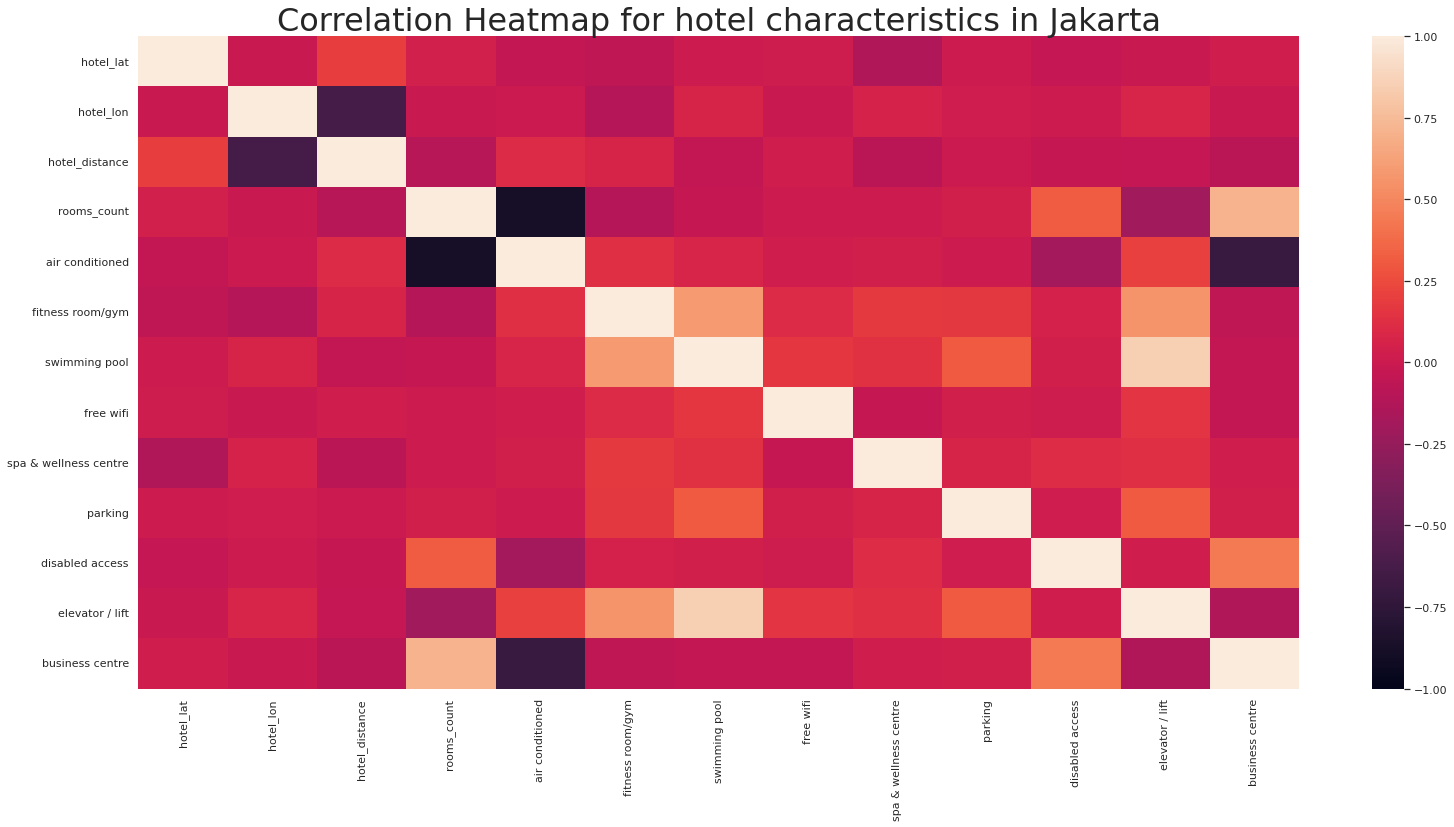

In [147]:

plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 36})
heatmap = sns.heatmap(indonesia.corr(),vmin=-1, vmax=1)
heatmap.set_title("Correlation Heatmap for hotel characteristics in Jakarta", fontdict={"fontsize":32})

Text(0.5, 1.0, 'Correlation Heatmap for hotel characteristics in London')

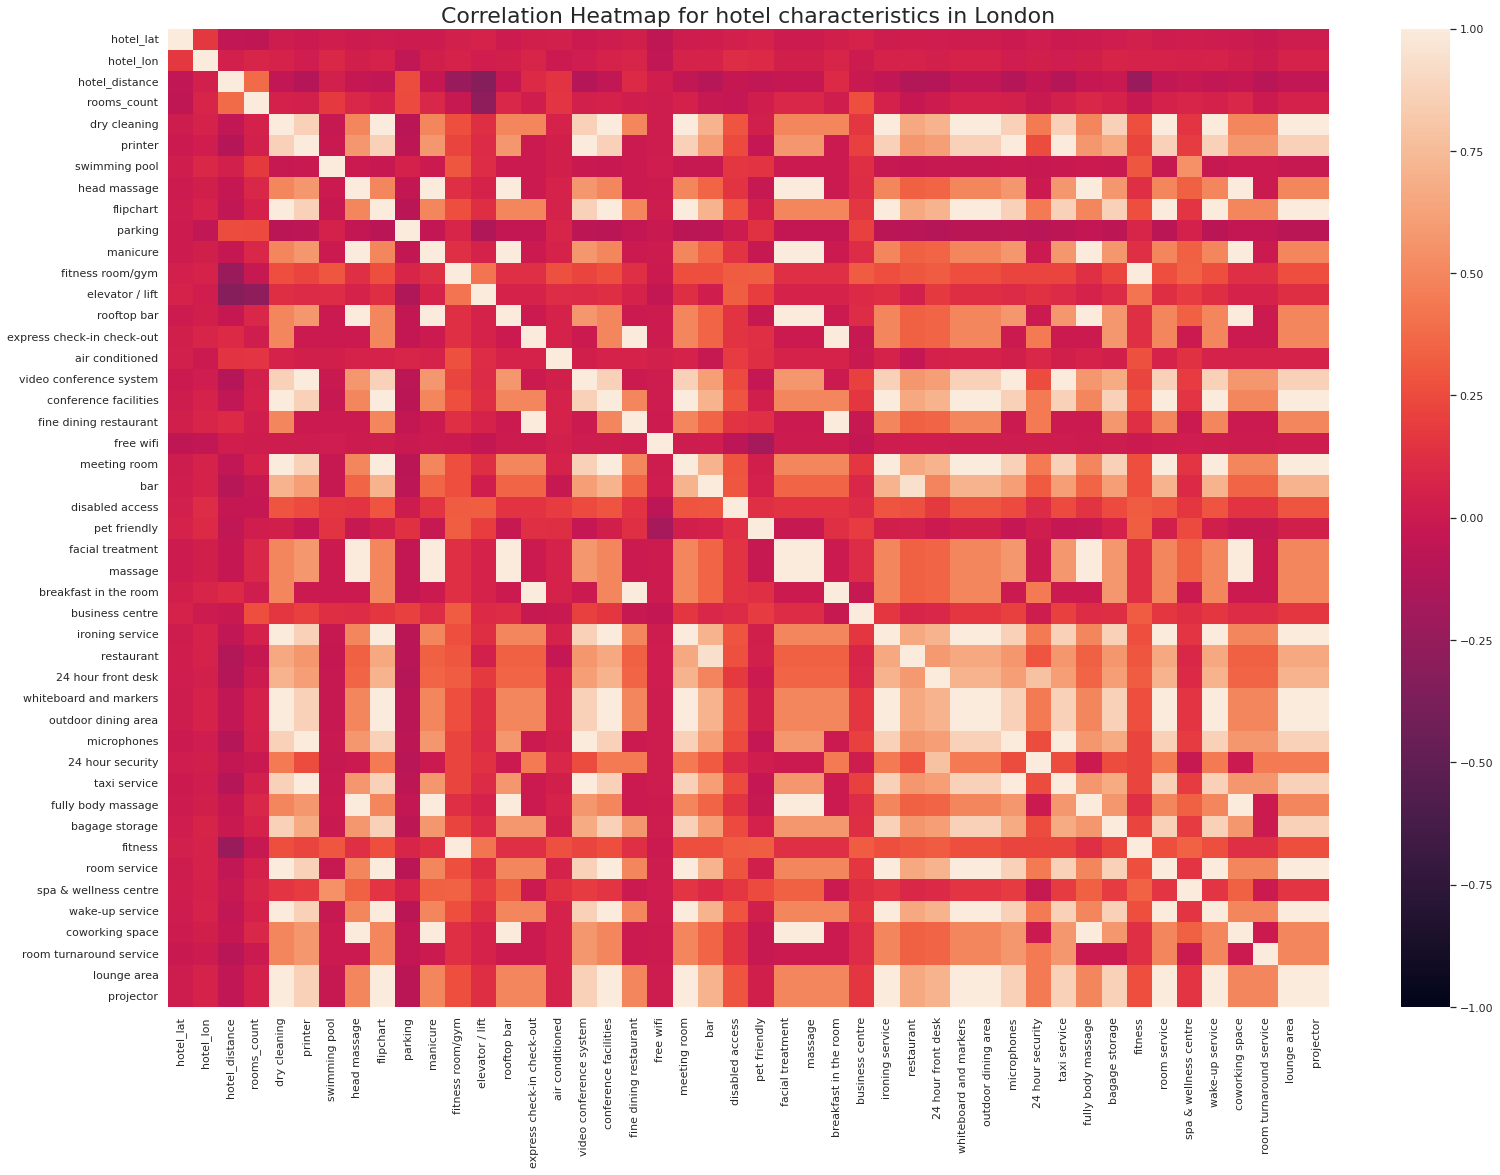

In [148]:

plt.figure(figsize=(26, 18))
plt.rcParams.update({'font.size': 22})
heatmap = sns.heatmap(gb.corr(),vmin=-1, vmax=1)
heatmap.set_title("Correlation Heatmap for hotel characteristics in London", fontdict={"fontsize":22})

### <br> Concusions: 
#### this time I showed the correlaton between amenities separately for each city:
#### - both cities shows different amount of amenities available in given hotels;
#### - most of amenities are highly correlated for London, so they are showing the same segment of characteristics;
#### - the same pairs of amenities showed slightly different level of correlation for Jakarta and London but the trend was similar for both cities<br>


## Data Reduction

#### <br> **calc_vif** - a function that detects strong correlation and returns list of characteristics that should be removed. Here in the function they are listed to ne removed only these characteristics for which the VIF score was higher than 5.
#### **reduce_dimensions_by_pca** -a function that will be reducing dimentions if in the final dataset there will still be a lot of variables. <br>

In [149]:
def calc_vif(df):
    # Multicollinearity detection
    # df - dataFrame
    # col_names - names of columns you would like to calculate the VIF score   
    vif = pd.DataFrame()

    variables = df
    df_vif = add_constant(variables)
    vif["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
    vif["variables"] = df_vif.columns
    vif["VIF"].replace([np.inf, -np.inf], np.nan, inplace=True)
    vifToReduce = vif.loc[(vif["VIF"].isnull())]
    return vifToReduce["variables"].tolist()

def select_variables(df, col_names):
    # returning the 
    if "const" in col_names:       
        const_to_remove = col_names.index("const")
        del col_names[const_to_remove]

    df_selected_variables = df
    df_selected_variables.drop(columns=col_names, inplace=True)

    return df_selected_variables

In [150]:
indonesia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 0 to 647
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   hotel_currency_code    648 non-null    object 
 1   hotel_lat              648 non-null    float64
 2   hotel_lon              648 non-null    float64
 3   hotel_distance         648 non-null    float64
 4   rooms_count            648 non-null    int64  
 5   hotel_type_en          648 non-null    object 
 6   air conditioned        648 non-null    int64  
 7   fitness room/gym       648 non-null    int64  
 8   swimming pool          648 non-null    int64  
 9   free wifi              648 non-null    int64  
 10  spa & wellness centre  648 non-null    int64  
 11  parking                648 non-null    int64  
 12  disabled access        648 non-null    int64  
 13  elevator / lift        648 non-null    int64  
 14  business centre        648 non-null    int64  
dtypes: flo

In [151]:
gb = gb.drop(columns=["hotel_currency_code","hotel_type_en"])
indonesia = indonesia.drop(columns=["hotel_currency_code","hotel_type_en"])

In [152]:
gbToReduce = calc_vif(gb)
idToReduce = calc_vif(indonesia)

/home/agata/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


#### <br> Removing from the working file variables which are highly correlated <br>

In [153]:
idReduced = select_variables(filesWorkingIDCleaned, idToReduce)
gbReduced = select_variables(filesWorkingGBCleaned, gbToReduce)

#### Creating copy that is not containing Hotel id for the analysis

In [154]:
idReducedAnalysis = idReduced.drop(columns=["hotel_id"])
gbReducedAnalysis = gbReduced.drop(columns=["hotel_id"])

In [155]:
#### ploting correlation heatmap for final hotel characteristics

(648, 15)

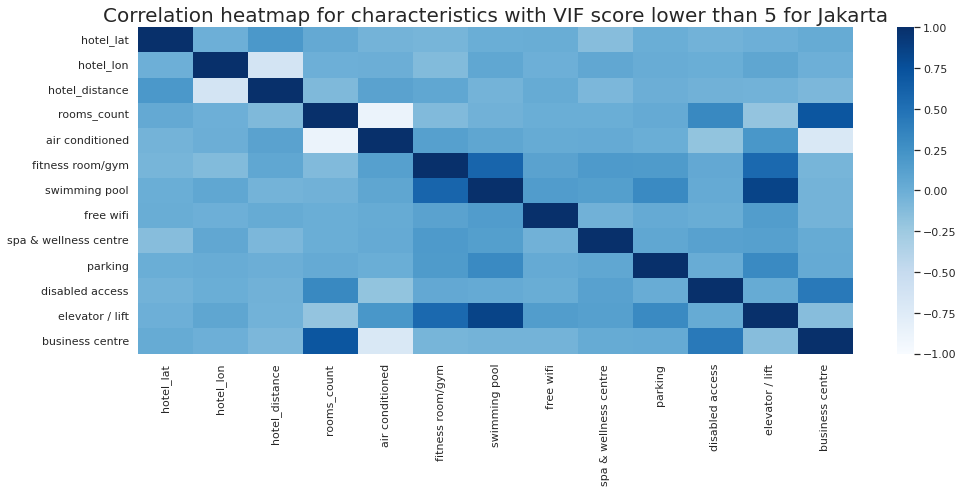

In [156]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(idReducedAnalysis.corr(),vmin=-1, vmax=1, cmap = "Blues")
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 20})
plt.savefig("heatmap.png", dpi = 300)
plt.title("Correlation heatmap for characteristics with VIF score lower than 5 for Jakarta", fontsize=20)
idReducedAnalysis.shape

(390, 15)

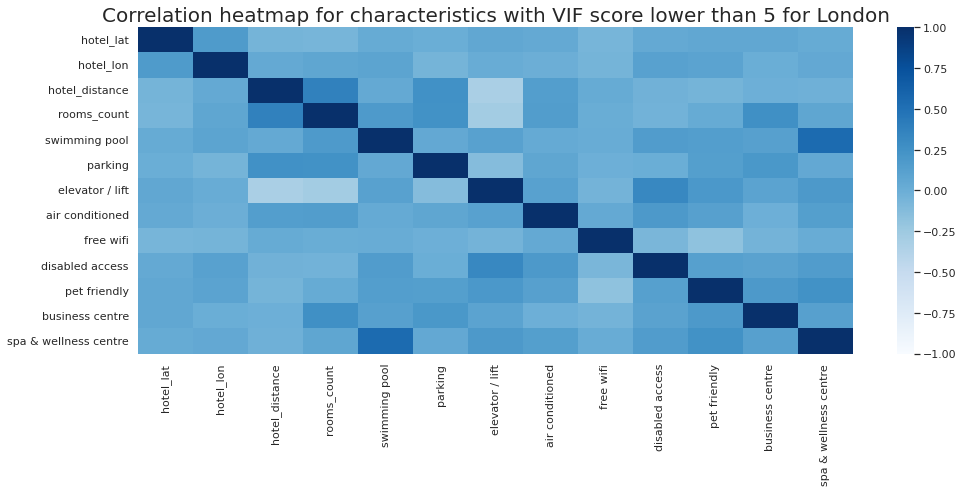

In [157]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(gbReducedAnalysis.corr(),vmin=-1, vmax=1, cmap = "Blues")
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 20})
plt.savefig("heatmap.png", dpi = 300)
plt.title("Correlation heatmap for characteristics with VIF score lower than 5 for London", fontsize=20)
gbReducedAnalysis.shape

### <br> Conclusions:
#### - this time  function detecting multcolinearity was removing characteristics VIF score higher that 5 what was recomended by documantation, it reduced the dimentions to 9 for Jakarta, 14 for London. <br>


## <br> DenseClus analysis<br>

## <br>There were performed 2 analysis:
#### 1. for Jakarta
#### 2. for London<br>

### <br> 1. Jakarta <br>

In [159]:
clf_indo = DenseClus(umap_combine_method="intersection_union_mapper")
clf_indo.fit(idReducedAnalysis)

/home/agata/anaconda3/lib/python3.7/site-packages/umap/umap_.py:1804: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


In [160]:
embedding = clf_indo.mapper_.embedding_
labels = clf_indo.score()
clustered = (labels >= 0)

cnts = pd.DataFrame(labels)[0].value_counts()
cnts = cnts.reset_index()
cnts.columns = ['cluster','count']
print(cnts.sort_values(['cluster']))

   cluster  count
1       -1    157
2        0    111
0        1    380


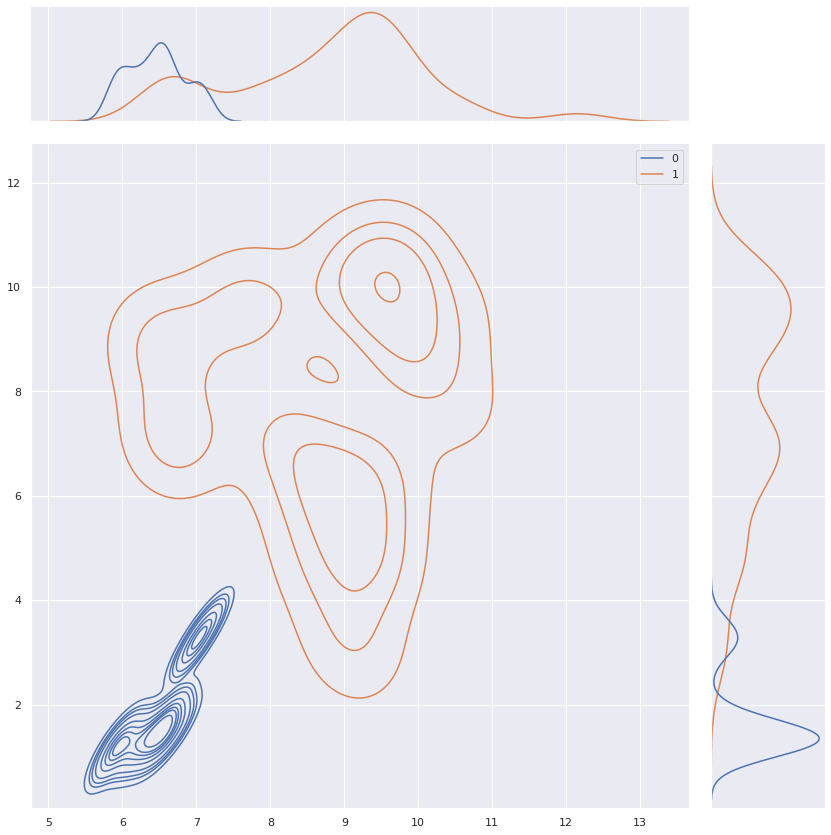

In [161]:
_=sns.jointplot(
    x=embedding[clustered, 0], y=embedding[clustered, 1], hue=labels[clustered], kind="kde", height=12)

In [162]:
coverage = np.sum(clustered) / embedding.shape[0]

print(f"Coverage {coverage}")
print(f"DBCV score {clf_indo.hdbscan_.relative_validity_}")

Coverage 0.7577160493827161
DBCV score 0.17955169984490088


### <br> Summary of general statistics for Jakarta clusters <br>
#### To assess the quality of produced clusters there a few metrics that can be used. Below I calculate the total number of clusters and total number of noice¶
#### which in other words mean that number of points that where not attached to any cluster. <br>

### 2. London

In [163]:
clf_gb = DenseClus(umap_combine_method="intersection_union_mapper")
clf_gb.fit(gbReducedAnalysis)

/home/agata/anaconda3/lib/python3.7/site-packages/umap/umap_.py:1804: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


In [164]:
embedding = clf_gb.mapper_.embedding_
labels = clf_gb.score()
clustered = (labels >= 0)

cnts = pd.DataFrame(labels)[0].value_counts()
cnts = cnts.reset_index()
cnts.columns = ['cluster','count']
print(cnts.sort_values(['cluster']))

   cluster  count
3       -1     12
1        0    121
2        1    112
0        2    145


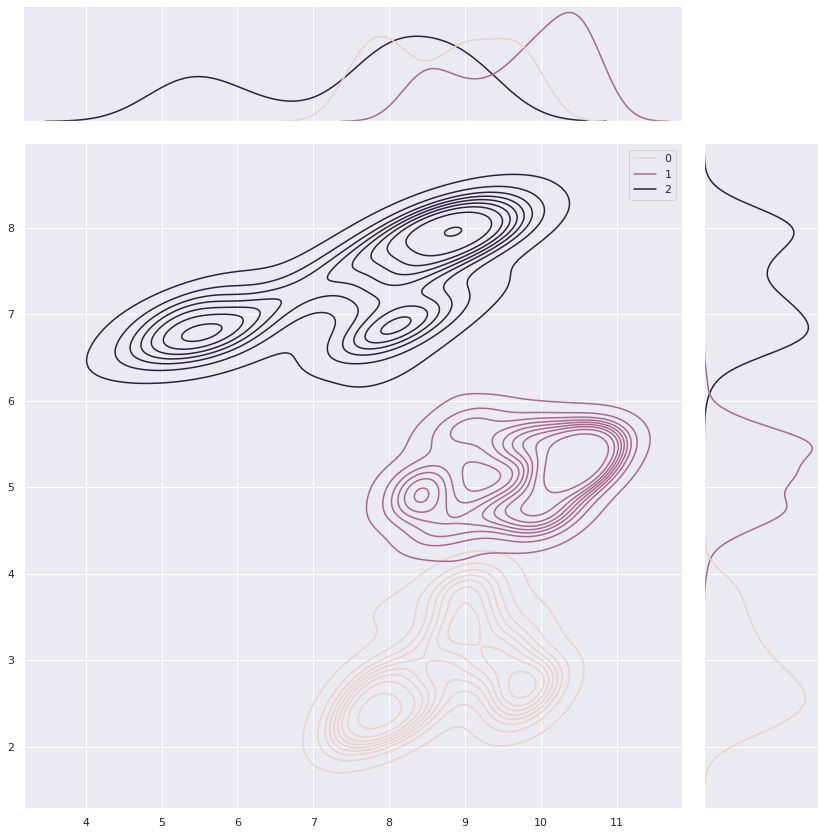

In [165]:
_=sns.jointplot(
    x=embedding[clustered, 0], y=embedding[clustered, 1], hue=labels[clustered], kind="kde", height=12
)

In [166]:
coverage = np.sum(clustered) / embedding.shape[0]

print(f"Coverage {coverage}")
print(f"DBCV score {clf_indo.hdbscan_.relative_validity_}")

Coverage 0.9692307692307692
DBCV score 0.17955169984490088


## <br> Concusions:<br>
#### 1. DenceClus package created a very few clusters: 2 for Jakarta and 3 for London so it is the best choice for our data.
#### 2. Coverage of the technique is very high but the DBCV is very low so this technique is not best fitted to that data types. <br>